# 사과 종 분류 과제

## 데이터 구조

```
$ DATA/
├── train/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── test/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
├── train_labels.csv (코드 실행 후 생성)
└── valid_labels.csv (코드 실행 후 생성)
```



## 0. 사전 준비

### 구글 드라이브 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### 데이터 압축 풀기

In [3]:
import os
os.chdir('/content/drive/MyDrive/apple_classification/DATA')

In [ ]:
# !unzip train.zip

In [ ]:
# !unzip test.zip

### 필요 라이브러리 설치

In [4]:
!pip install timm
!pip install -U scikit-learn
!pip install wandb -qU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 7.6 MB/s 
     |████████████████████████████████| 182 kB 64.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.3 MB/s 
     |████████████████████████████████| 168 kB 47.8 MB/s 
     |████████████████████████████████| 182 kB 62.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 66.8 MB/s 
     |████████████████████████████████| 166 kB 50.2 MB/s 
     |████████████████████████████████| 166 kB 78.5 MB/s 
     |████████████████████████████████| 162 kB 62.2 MB/s 
     |████████████████████████████████| 162 kB 67.6 MB/s 
     |████████████████████████████████| 158 kB 72.1 MB/s 
     |████████████████████████████████| 157 kB 79.1 MB/s 
     |████████████████████████████████| 157 kB 69.3 

## 1. 라이브러리 불러오기

In [6]:
from torch.utils.data import DataLoader
import torch

from datetime import datetime, timezone, timedelta
import numpy as np
import random
import os
import copy

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import timm
from torch import nn

from sklearn.metrics import accuracy_score, f1_score

import os
import wandb
wandb.login()

# wandb might cause an error without this.
os.environ["WANDB_START_METHOD"] = "thread"

wandb: Currently logged in as: jofmjh. Use `wandb login --relogin` to force relogin


## 2. 경로 / 기타 인자 설정

### 데이터 경로 설정

In [7]:
# 프로젝트 경로
PROJECT_DIR = '/content/drive/MyDrive/apple_classification'
os.chdir(PROJECT_DIR)

# 데이터 경로
DATA_DIR = os.path.join(PROJECT_DIR, 'DATA')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'train.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
TEST_LABEL_DIR = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_DIR = os.path.join(DATA_DIR, 'sample_submission.csv')

In [8]:
# 파일 수 확인 
print(len(os.listdir(TRAIN_IMG_DIR)))
print(len(os.listdir(TEST_IMG_DIR)))

10000
5000


### 결과 저장 경로 설정

In [9]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

In [10]:
RECORDER_DIR

'/content/drive/MyDrive/apple_classification/results/train/20221123_152916'

### 시드 설정

In [11]:
# 시드
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 디바이스 설정

In [12]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

## 3. 데이터 불러오기 및 분할

### Train 라벨

In [14]:
# 학습 파일
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


### Train 이미지 예시

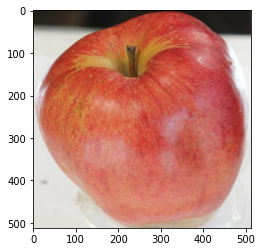

In [ ]:
# 이미지 예시
example_index = random.randrange(len(traindf)) # 0,1,2,...
example_imageid = traindf['img_id'][example_index]
example_image_path = os.path.join(TRAIN_IMG_DIR, example_imageid)
example_image = Image.open(example_image_path)

plt.imshow(example_image)

In [ ]:
example_image.size

(512, 512)

### Train / Validation 분할

In [15]:
# 80% / 20% 비율로 분할
train,val = train_test_split(traindf, test_size=0.2, shuffle=True)

# train / validation로 나눈 데이터 프레임 저장
train.to_csv(os.path.join(DATA_DIR, 'train_labels.csv'), index=False)
val.to_csv(os.path.join(DATA_DIR, 'val_labels.csv'),index=False)

In [16]:
len(train)

8000

## 4. Dataset 

### Dataset 클래스 정의

In [17]:
class AppleDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath, usecols=['img_id','a_type'],dtype={'a_type':str})
    self.label_encoding = {'HJ':0, 'HR':1, 'SG':2, 'AR':3}
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])  
    self.img_ids = list(self.df['img_id'])
    self.labels = list(self.df['a_type'])
  
  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    lbl = self.labels[index]
    lbl = self.label_encoding[lbl]
    return img,lbl


## 5. 모델 정의

### 모델 Class 생성

In [ ]:
F = nn.functional

class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    # 합성곱 층
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,3,3,4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(3,3,3,padding=1)

    # 완전 연결 층
    self.fc1 = nn.Linear(3072, 1036)
    self.fc2 = nn.Linear(1036, 518)
    self.fc3 = nn.Linear(518, 4)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)   
    return output
  
class EffNet(nn.Module):
  def __init__(self, trial):
    super(EffNet, self).__init__()
    self.trial = trial
    
    self.model = timm.create_model('efficientnet_b4', pretrained=True)
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(625,256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )
    for param in self.model.parameters():
      param.requires_grad = False
    for param in self.model.classifier.parameters():
      param.requires_grad = True
  
  def forward(self, x):
    output = self.model(x)
    return output

In [18]:
# optuna적용

F = nn.functional

class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    # 합성곱 층
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,3,3,4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(3,3,3,padding=1)

    # 완전 연결 층
    self.fc1 = nn.Linear(3072, 1036)
    self.fc2 = nn.Linear(1036, 518)
    self.fc3 = nn.Linear(518, 4)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)   
    return output
  
class EffNet(nn.Module):
  def __init__(self, trial):
    super(EffNet, self).__init__()
    self.trial = trial
    
    self.model = timm.create_model('efficientnet_b4', pretrained=True)
    out_features = trial.suggest_int("out_features", 400, 800)
    p = trial.suggest_float("dropout", 0.3, 0.5)
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1792, out_features = out_features),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(out_features,256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )
    for param in self.model.parameters():
      param.requires_grad = False
    for param in self.model.classifier.parameters():
      param.requires_grad = True
  
  def forward(self, x):
    output = self.model(x)
    return output

### 모델 선택 함수

In [ ]:
def get_model(model_name:str):
  if model_name == 'Custom':
    return CustomNet()
  if model_name == 'effnet':
    return EffNet()

## 6. 학습

### DataLoader 관련 인자 설정

In [19]:
# Dataloader 관련 인자
BATCH_SIZE = 16
NUM_WORKERS = 1
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = False

### Dataset 및 DataLoader 생성



In [20]:
# 데이터 셋 정의
train_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'train_labels.csv'))
valid_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'val_labels.csv'))

# 데이터 로더 정의
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

In [ ]:
len(train_dataset)

8000

### 모델 설정

In [31]:
# Hyperparameter 설정
LEARNING_RATE = 5e-5
EPOCHS = 4

In [22]:
# Loss와 optimizer 설정
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### 학습 진행

In [23]:
!pip install --quiet optuna

     |████████████████████████████████| 348 kB 6.9 MB/s 
     |████████████████████████████████| 209 kB 67.6 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 147 kB 62.5 MB/s 
     |████████████████████████████████| 112 kB 58.8 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 


In [24]:
import optuna
import torch.optim as optim
from optuna.trial import TrialState

In [32]:
def objective(trial):
    
    # Generate the model.
    #global model
    #model = model(trial).to(device)
    model = EffNet(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)


    # init tracking experiment.
    # hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init(
        project="apple_classification",
        entity="jofmjh",  # NOTE: this entity depends on your wandb account.
        config=config,
        # group=STUDY_NAME,
        reinit=True,
    )

    best_loss = np.Inf
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        train_total_loss = 0
        target_list = [] # 실제 사과 종 추가할 리스트 
        pred_list = []  # 예측 사과 종 추가할 리스트
        for batch_index, (x,y) in tqdm(enumerate(train_dataloader)):
          x,y = x.to(device), y.to(device)                          # x - image data, y - 실제 label을 GPU로 옮김 
          y_pred = model(x)                                         # 모델을 통해 나온 output
          loss = criterion(y_pred, y)                               # 실제값 y와 예측값 y_pred로 loss 계산
          optimizer.zero_grad()                                     # optimizer 초기화
          loss.backward()                                           # gradient 계산
          optimizer.step()                                          # 역전파
          train_total_loss += loss.item()                           # train_total_loss에 loss값을 누적
          pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())     # 예측한 값중 가장 높은 값의 인덱스를 추가
          target_list.extend(y.cpu().tolist())                      # 실제 label 인덱스를 추가 
        train_mean_loss = train_total_loss / batch_index            # 에폭의 평균 loss
        train_accuracy = accuracy_score(target_list, pred_list)     # accuracy_score
        train_f1score = f1_score(target_list, pred_list, average='macro')  # macro - f1 Score


        # Validation of the model.
        model.eval()                                                # 학습 모드를 검증 모드로 변경
        val_total_loss = 0                                          
        target_list = []                                            
        pred_list = []
        with torch.no_grad():                                       # 역전파 하지 않음
          for batch_index, (x,y) in tqdm(enumerate(valid_dataloader)):    
            x = x.to(device)                                         
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            #
            val_total_loss += loss.item()
            target_list.extend(y.cpu().tolist())
            pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())
        val_mean_loss = val_total_loss / batch_index
        val_accuracy = accuracy_score(target_list, pred_list)
        val_f1score = f1_score(target_list, pred_list, average='macro')

        msg1 = f"Epoch {epoch+1}/{EPOCHS} - Train loss: {train_mean_loss}; Train Accuracy: {train_accuracy}; Train F1: {train_f1score}"
        msg2 = f"Valid loss: {val_mean_loss}; Val Accuracy: {val_accuracy}; Val F1: {val_f1score}"
        print(msg1)
        print(msg2)

        

        ### 결과 저장 ###
        # validation loss가 개선될 때 모델 저장
        if val_mean_loss < best_loss:                               
          best_loss = val_mean_loss

          check_point = {                                         
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
          }
          torch.save(check_point, os.path.join(RECORDER_DIR,f'loss:{best_loss : .3f},f1score:{val_f1score : .3f}: best.pt')) 

        # Handle pruning based on the intermediate value.
        # if trial.should_prune():
        #     raise optuna.exceptions.TrialPruned()

        trial.report(val_f1score, epoch)

        # report validation f1 score to wandb
        wandb.log(data={"validation f1 score": val_f1score}, step=epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            wandb.run.summary["state"] = "pruned"
            wandb.finish(quiet=True)
            raise optuna.exceptions.TrialPruned()

    # report the final validation accuracy to wandb
    wandb.run.summary["final f1 score"] = val_f1score
    wandb.run.summary["state"] = "complated"
    wandb.finish(quiet=True)
    
    return val_f1score

In [33]:
study = optuna.create_study(
    direction="maximize",
    study_name="apple",
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective, n_trials=15)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-23 07:02:43,129] A new study created in memory with name: apple


validation f1 score,▁▇█
validation f1 score,0.84754


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 1/4 - Train loss: 0.3540368134040154; Train Accuracy: 0.868375; Train F1: 0.7827054987803184
Valid loss: 0.15506882289604795; Val Accuracy: 0.947; Val F1: 0.9189021536583496


500it [02:30,  3.31it/s]
125it [00:34,  3.59it/s]


Epoch 2/4 - Train loss: 0.1909698981704015; Train Accuracy: 0.93; Train F1: 0.8949263605875237
Valid loss: 0.13540668244804105; Val Accuracy: 0.9465; Val F1: 0.9181720885773252


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 3/4 - Train loss: 0.14866342146335942; Train Accuracy: 0.947125; Train F1: 0.9216891571210629
Valid loss: 0.12205409741539869; Val Accuracy: 0.956; Val F1: 0.9322882368367351


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 4/4 - Train loss: 0.1388429031013987; Train Accuracy: 0.95125; Train F1: 0.9294624824422759
Valid loss: 0.11235513087857756; Val Accuracy: 0.9605; Val F1: 0.9400623366349612


[I 2022-11-23 07:15:18,279] Trial 0 finished with value: 0.9400623366349612 and parameters: {'out_features': 606, 'dropout': 0.49796302235348316, 'optimizer': 'Adam', 'lr': 0.0005701289346404282}. Best is trial 0 with value: 0.9400623366349612.


500it [02:31,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 1.0161502134943294; Train Accuracy: 0.619625; Train F1: 0.29379479404949105
Valid loss: 0.6450155822019423; Val Accuracy: 0.7975; Val F1: 0.46624506618996087


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.5105697365108138; Train Accuracy: 0.84725; Train F1: 0.6420861195708029
Valid loss: 0.3717347524699665; Val Accuracy: 0.888; Val F1: 0.6947577219583523


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 3/4 - Train loss: 0.36548273160844624; Train Accuracy: 0.874875; Train F1: 0.6892224896736932
Valid loss: 0.29341098149457284; Val Accuracy: 0.892; Val F1: 0.7133188358597179


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 4/4 - Train loss: 0.3063986930914059; Train Accuracy: 0.886125; Train F1: 0.737193918171786
Valid loss: 0.2565118404886415; Val Accuracy: 0.914; Val F1: 0.8256707100539229


[I 2022-11-23 07:27:49,783] Trial 1 finished with value: 0.8256707100539229 and parameters: {'out_features': 560, 'dropout': 0.3363881278399112, 'optimizer': 'Adam', 'lr': 1.710347725901047e-05}. Best is trial 0 with value: 0.9400623366349612.


500it [02:31,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 1/4 - Train loss: 0.3368361197815152; Train Accuracy: 0.87725; Train F1: 0.8002573319983763
Valid loss: 0.1831346873734747; Val Accuracy: 0.9455; Val F1: 0.9187597718093505


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 2/4 - Train loss: 0.18213351562578148; Train Accuracy: 0.9335; Train F1: 0.8996415719979838
Valid loss: 0.16258856059510202; Val Accuracy: 0.947; Val F1: 0.9253066213200452


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 3/4 - Train loss: 0.14443661616312597; Train Accuracy: 0.947; Train F1: 0.9210423589299358
Valid loss: 0.12923211431517567; Val Accuracy: 0.9585; Val F1: 0.9383276735592818


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 4/4 - Train loss: 0.12298467421259372; Train Accuracy: 0.954875; Train F1: 0.933562003536997
Valid loss: 0.12856035589028314; Val Accuracy: 0.955; Val F1: 0.9292564800464469


[I 2022-11-23 07:40:21,158] Trial 2 finished with value: 0.9292564800464469 and parameters: {'out_features': 673, 'dropout': 0.4129101721677213, 'optimizer': 'Adam', 'lr': 0.0009979597462358102}. Best is trial 0 with value: 0.9400623366349612.


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.409325721152948; Train Accuracy: 0.85125; Train F1: 0.7372917794414743
Valid loss: 0.1791610375587498; Val Accuracy: 0.9375; Val F1: 0.8971573984172447


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.18961635461536222; Train Accuracy: 0.9315; Train F1: 0.8946624585465588
Valid loss: 0.14463520422577858; Val Accuracy: 0.9485; Val F1: 0.921171252614023


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 3/4 - Train loss: 0.1486536691913415; Train Accuracy: 0.94525; Train F1: 0.9190673177203499
Valid loss: 0.11432965368693394; Val Accuracy: 0.96; Val F1: 0.9403965549639879


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 4/4 - Train loss: 0.12890849018307077; Train Accuracy: 0.954375; Train F1: 0.933350660396511
Valid loss: 0.1089288842575174; Val Accuracy: 0.9585; Val F1: 0.9348280478455809


[I 2022-11-23 07:52:52,437] Trial 3 finished with value: 0.9348280478455809 and parameters: {'out_features': 455, 'dropout': 0.3615384627045803, 'optimizer': 'Adam', 'lr': 0.00022506999609691025}. Best is trial 0 with value: 0.9400623366349612.


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.7044793176866008; Train Accuracy: 0.756375; Train F1: 0.5475372718726815
Valid loss: 0.4062837935503452; Val Accuracy: 0.8835; Val F1: 0.6891341684761627


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.37958777318139353; Train Accuracy: 0.87175; Train F1: 0.6844022910506122
Valid loss: 0.28646781803258964; Val Accuracy: 0.893; Val F1: 0.7102589881725194


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 3/4 - Train loss: 0.3049146005424684; Train Accuracy: 0.888375; Train F1: 0.7466008921263585
Valid loss: 0.24141608025397984; Val Accuracy: 0.907; Val F1: 0.7903291843831306


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 4/4 - Train loss: 0.26549581156106655; Train Accuracy: 0.905625; Train F1: 0.8210900234857353
Valid loss: 0.21221393707298464; Val Accuracy: 0.9185; Val F1: 0.8361225649094484


[I 2022-11-23 08:05:23,960] Trial 4 finished with value: 0.8361225649094484 and parameters: {'out_features': 483, 'dropout': 0.44169309416654046, 'optimizer': 'RMSprop', 'lr': 3.269146037185747e-05}. Best is trial 0 with value: 0.9400623366349612.


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.4777508319424603; Train Accuracy: 0.830375; Train F1: 0.6464748458109586
Valid loss: 0.25557560248360517; Val Accuracy: 0.909; Val F1: 0.7939284111196525


[I 2022-11-23 08:08:37,047] Trial 5 pruned. 


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 1/4 - Train loss: 0.8870862917694634; Train Accuracy: 0.66525; Train F1: 0.39729906017426153
Valid loss: 0.5814374543486103; Val Accuracy: 0.8505; Val F1: 0.6452628855229517


[I 2022-11-23 08:11:50,408] Trial 6 pruned. 


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.5010585114882441; Train Accuracy: 0.816625; Train F1: 0.6652451513157066
Valid loss: 0.21370906800392173; Val Accuracy: 0.9215; Val F1: 0.8417919615556839


[I 2022-11-23 08:15:03,685] Trial 7 pruned. 


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.3114758380922024; Train Accuracy: 0.886125; Train F1: 0.8046233337694418
Valid loss: 0.17247011413001606; Val Accuracy: 0.936; Val F1: 0.8919570361480007


[I 2022-11-23 08:18:17,165] Trial 8 pruned. 


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.3048724162733865; Train Accuracy: 0.89; Train F1: 0.822852221903738
Valid loss: 0.1658008715303074; Val Accuracy: 0.942; Val F1: 0.9164615336361802


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.16611533053499275; Train Accuracy: 0.9415; Train F1: 0.9115697312071119
Valid loss: 0.12539928392394475; Val Accuracy: 0.9555; Val F1: 0.9259895954226406


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 3/4 - Train loss: 0.1462251536500545; Train Accuracy: 0.947125; Train F1: 0.9206265327488439
Valid loss: 0.1133178103069264; Val Accuracy: 0.959; Val F1: 0.9369430763578935


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 4/4 - Train loss: 0.12652944941876199; Train Accuracy: 0.953125; Train F1: 0.9307623978586923
Valid loss: 0.1052555350705065; Val Accuracy: 0.9615; Val F1: 0.9383521952238065


[I 2022-11-23 08:30:48,714] Trial 9 finished with value: 0.9383521952238065 and parameters: {'out_features': 516, 'dropout': 0.42153470464566445, 'optimizer': 'RMSprop', 'lr': 0.0004713043042805701}. Best is trial 0 with value: 0.9400623366349612.


500it [02:31,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.3158882112412122; Train Accuracy: 0.889875; Train F1: 0.8290487515571137
Valid loss: 0.15707783818605445; Val Accuracy: 0.9435; Val F1: 0.9078921053348445


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.19145576892194818; Train Accuracy: 0.93475; Train F1: 0.901158167508752
Valid loss: 0.14256956524425937; Val Accuracy: 0.947; Val F1: 0.9198380091996012


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 3/4 - Train loss: 0.15700823072818124; Train Accuracy: 0.942125; Train F1: 0.9154646800552002
Valid loss: 0.11763802047954092; Val Accuracy: 0.9565; Val F1: 0.9317481619994112


[I 2022-11-23 08:40:15,283] Trial 10 pruned. 


500it [02:30,  3.31it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.31576805643528283; Train Accuracy: 0.88975; Train F1: 0.820466071632494
Valid loss: 0.16258417189707078; Val Accuracy: 0.938; Val F1: 0.8912405139660502


[I 2022-11-23 08:43:29,431] Trial 11 pruned. 


500it [02:31,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 1/4 - Train loss: 0.4449222288085129; Train Accuracy: 0.835625; Train F1: 0.7106870472727836
Valid loss: 0.2055625511002877; Val Accuracy: 0.9285; Val F1: 0.8792058390319516


[I 2022-11-23 08:46:45,111] Trial 12 pruned. 


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 1/4 - Train loss: 0.3177363249941735; Train Accuracy: 0.8855; Train F1: 0.8117721913580641
Valid loss: 0.1603725554736992; Val Accuracy: 0.947; Val F1: 0.9150935004450605


500it [02:30,  3.32it/s]
125it [00:34,  3.60it/s]


Epoch 2/4 - Train loss: 0.1774311163579347; Train Accuracy: 0.93575; Train F1: 0.904482947504814
Valid loss: 0.1383714620399499; Val Accuracy: 0.9455; Val F1: 0.9147680478708264


[I 2022-11-23 08:53:05,325] Trial 13 pruned. 


500it [02:30,  3.32it/s]
125it [00:34,  3.61it/s]


Epoch 1/4 - Train loss: 0.3268755823784398; Train Accuracy: 0.880625; Train F1: 0.8092272405423382
Valid loss: 0.15022543237184086; Val Accuracy: 0.948; Val F1: 0.9184134780812221


500it [02:30,  3.31it/s]
125it [00:34,  3.59it/s]


Epoch 2/4 - Train loss: 0.18769260422645775; Train Accuracy: 0.933625; Train F1: 0.9035232091468495
Valid loss: 0.1285278602689129; Val Accuracy: 0.9545; Val F1: 0.9248115643960346


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]


Epoch 3/4 - Train loss: 0.1540572867830954; Train Accuracy: 0.94525; Train F1: 0.919158849494234
Valid loss: 0.10505432724922655; Val Accuracy: 0.963; Val F1: 0.9437662985561845


500it [02:30,  3.31it/s]
125it [00:34,  3.60it/s]

Epoch 4/4 - Train loss: 0.13207591781653985; Train Accuracy: 0.950875; Train F1: 0.9266361504776592
Valid loss: 0.12556452268073637; Val Accuracy: 0.958; Val F1: 0.9290535929443907


[I 2022-11-23 09:05:37,017] Trial 14 finished with value: 0.9290535929443907 and parameters: {'out_features': 662, 'dropout': 0.4650451730322307, 'optimizer': 'RMSprop', 'lr': 0.0005851665347839439}. Best is trial 0 with value: 0.9400623366349612.


Study statistics: 
  Number of finished trials:  15
Best trial:
  Value:  0.9400623366349612
  Params: 
    out_features: 606
    dropout: 0.49796302235348316
    optimizer: Adam
    lr: 0.0005701289346404282


In [34]:
optuna.visualization.plot_optimization_history(study)

In [35]:
optuna.visualization.plot_slice(study)

## 7. 추론

### 데이터 셋 설정

In [ ]:
class TestDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath , usecols=['img_id'],dtype={'img_id':str})
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
    self.img_ids = list(self.df['img_id'])
      
  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    img_ids = self.img_ids[index]
    
    return img,img_ids

#### 모델설정

In [ ]:
# 모델 Load
model = EffNet(trial)
#model = get_model('effnet')
checkpoint = torch.load(os.path.join(RECORDER_DIR, "loss: 0.116,f1score: 0.949: best.pt"))
model.load_state_dict(checkpoint['model'])
model.to(device)

### Dataset 및 DataLoader 설정

In [ ]:
# Dataloader 관련 인자
BATCH_SIZE = 1
NUM_WORKERS = 1
SHUFFLE = False
PIN_MEMORY = True
DROP_LAST = False

In [ ]:
# Dataset
test_dataset = TestDataset(img_folder = TEST_IMG_DIR, labelpath = os.path.join(TEST_LABEL_DIR))


# DataLoader
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 추론 진행

In [ ]:
model.eval()      # 학습 모드를 검증 모드로 변경

# 예측 진행
y_preds = []
img_ids = []

for batch_index, (x, img_id) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = model(x).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_pred = y_pred.cpu().tolist()
    img_ids.extend(img_id)
    y_preds.extend(y_pred)

100%|██████████| 5000/5000 [16:34<00:00,  5.03it/s]


### 추론 결과 저장

In [ ]:
# 결과 데이터 프레임 생성 및 라벨 디코딩
pred_df = pd.DataFrame(list(zip(img_ids, y_preds)), columns=['img_id','a_type'])
label_decoding = {0:'HJ', 1:'HR', 2:'SG', 3:'AR'}
pred_df['a_type'] = pred_df['a_type'].replace(label_decoding)

In [ ]:
# 샘플과 동일한 순서로 변경
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['img_id'])
resdf = pred_df.set_index('img_id')
result = resdf.loc[sorter].reset_index()

In [ ]:
result

,img_id,a_type
0,VXKQzkmgbf.jpg,HJ
1,2JFr2uJU79.jpg,HJ
2,twROnuoPeB.jpg,HR
3,b8mY8Szmhb.jpg,HJ
4,tcPc4JOUkG.jpg,HR
...,...,...
4995,kUAVadtfy1.jpg,HJ
4996,qXGjcfOaj4.jpg,HJ
4997,xLnjiHkkp9.jpg,SG
4998,Hvf9rxz3FM.jpg,HJ


In [ ]:
result.to_csv(os.path.join(RECORDER_DIR,'result.csv'),index=False)